<h1 style="text-align: center;" markdown="1">Cyclopterus lumpus</h1>
<h3 style="text-align: center;" markdown="1">Lumpfish genome assembly project</h3>

-----

In [3]:
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import plotly.graph_objs as go
import pytablewriter

from pycoQC.pycoQC import pycoQC
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode (connected=False)

#%load_ext rpy2.ipython

def reads_1D_data (df, field_name="num_bases", xscale="linear", nbins=200, smooth_sigma=2, sample=1000000):
        """Private function preparing data for reads_len_1D and reads_qual_1D"""
        # Downsample if needed
        if sample and len(df)>sample:
            df = df.sample(sample)

            
       
        #Extract data field from df
        data = df[field_name].values

        # Count each categories in log or linear space
        min = np.nanmin(data)
        max = np.nanmax(data)
        if xscale == "log":
            count_y, bins = np.histogram (a=data, bins=np.logspace (np.log10(min), np.log10(max)+0.1, nbins))
        elif xscale == "linear":
            count_y, bins = np.histogram (a=data, bins= np.linspace (min, max, nbins))

        # Remove last bin from labels
        count_x = bins[1:]

        # Smooth results with a savgol filter
        if smooth_sigma:
            count_y = gaussian_filter1d (count_y, sigma=smooth_sigma)

        # Get percentiles percentiles
        stat = np.percentile (data, [10,25,50,75,90])
        y_max = count_y.max()

        data_dict = dict (
            x = [count_x, [stat[0],stat[0]], [stat[1],stat[1]], [stat[2],stat[2]], [stat[3],stat[3]], [stat[4],stat[4]]],
            y = [count_y, [0,y_max], [0,y_max], [0,y_max], [0,y_max], [0,y_max]],
            name = ["Density", "10%", "25%", "Median", "75%", "90%"],
            text = ["",
                ["", "10%<br>{:,.2f}".format(stat[0])],
                ["", "25%<br>{:,.2f}".format(stat[1])],
                ["", "Median<br>{:,.2f}".format(stat[2])],
                ["", "75%<br>{:,.2f}".format(stat[3])],
                ["", "90%<br>{:,.2f}".format(stat[4])]],
        )

        # Make layout dict = Off set for labels on top
        layout_dict = {"yaxis.range": [0, y_max+y_max/6]}

        return data_dict, layout_dict

# <center>General Info</center>

<h3 style="text-align: center;" markdown="1">2n = 50   <br>
Estimated genome size = 600 Mbases
<br><br>

|  id | value  |
|---|---|
|Sequenced fish id   | ?  |
| Sample freezer coordinates  | ?  |
| Sequencing center  |  CIGENE |
| Machine |  PromethION |
|   Flowcell type | FLO-PRO002 |   |
| Lib prep | SQK-LSK109  |   |
|Sequencing runs |              2 |
   
   
Raw data: `\$(find /mnt/smb/labfile/Backup/PromethION/basecalled/*Lump* -name \*fastq.gz |grep -v chopped)`   <br>
Porechopped data: `\$(find /mnt/smb/labfile/Backup/PromethION/basecalled/*Lump* -name \*chopped.fastq.gz)`   <br>
Quality filtered data: `/net/fs-1/projects01/TRANSPOSE/Rawdata/PromethION/prom-lumpy-20190115.min4k.q7.h50.fastq.gz` 


# <center>Sequencing </center>
## <center> raw data </center>

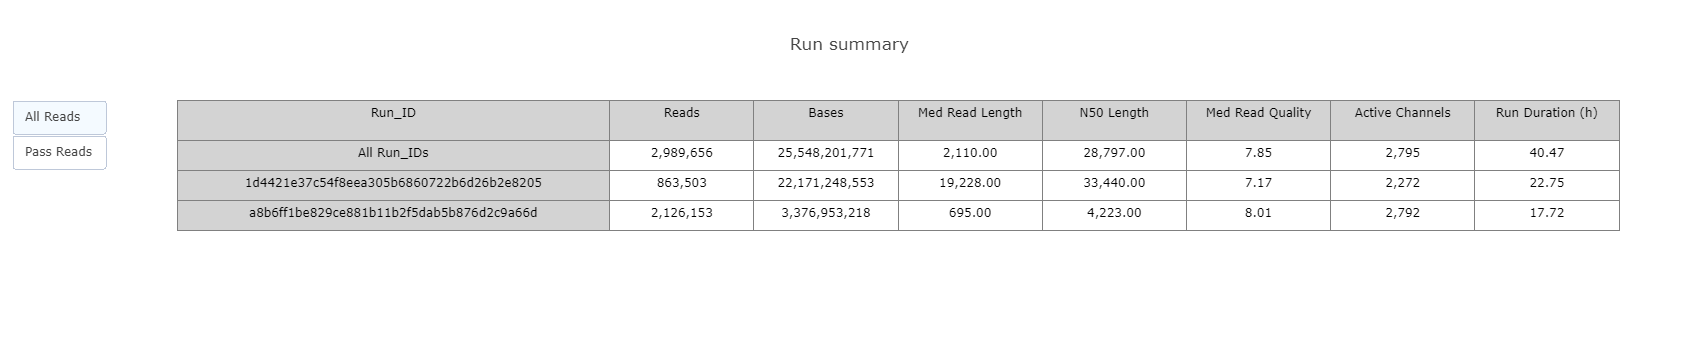

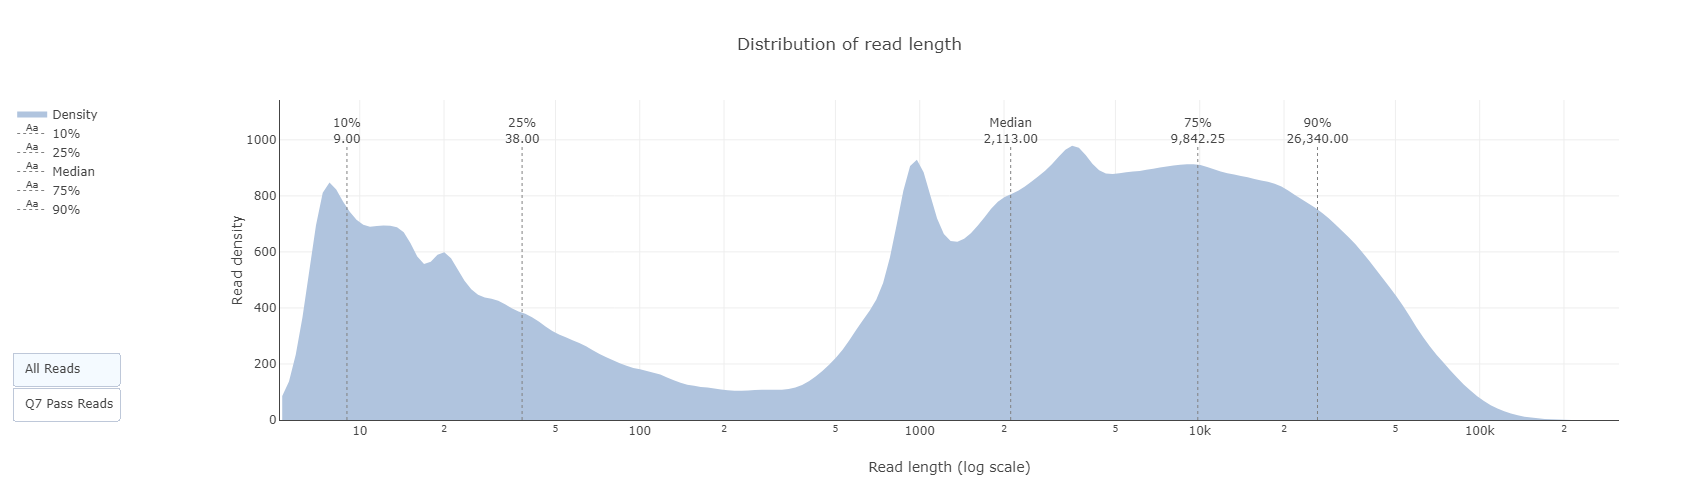

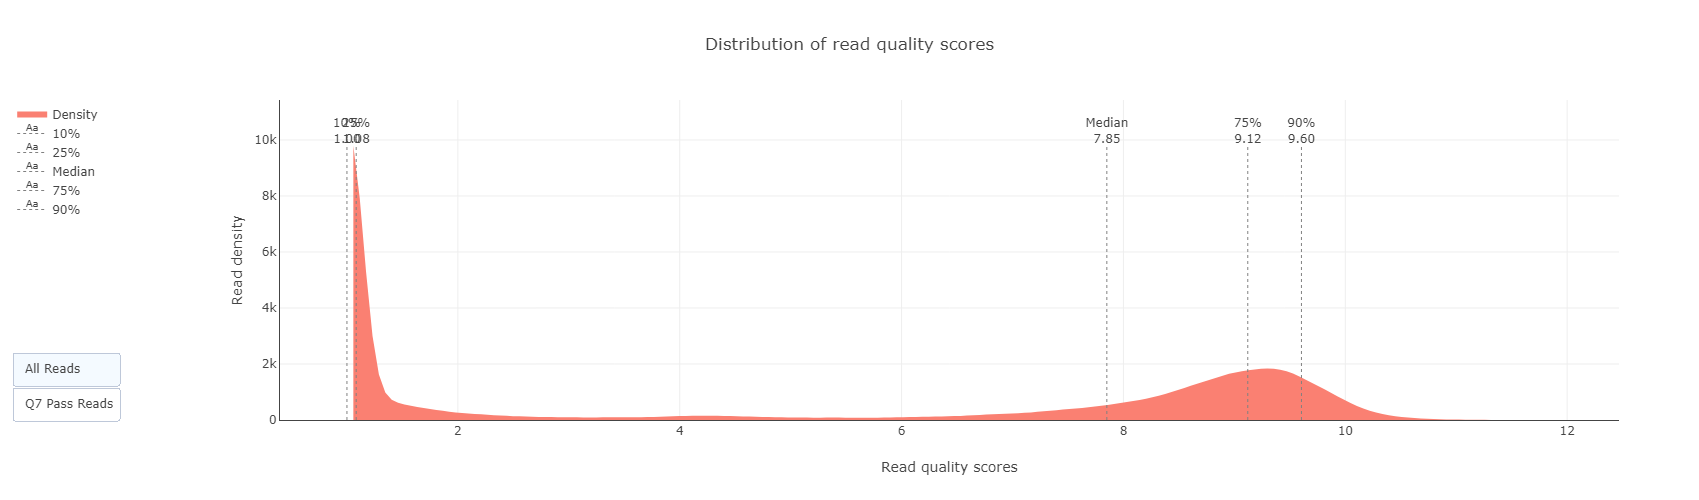

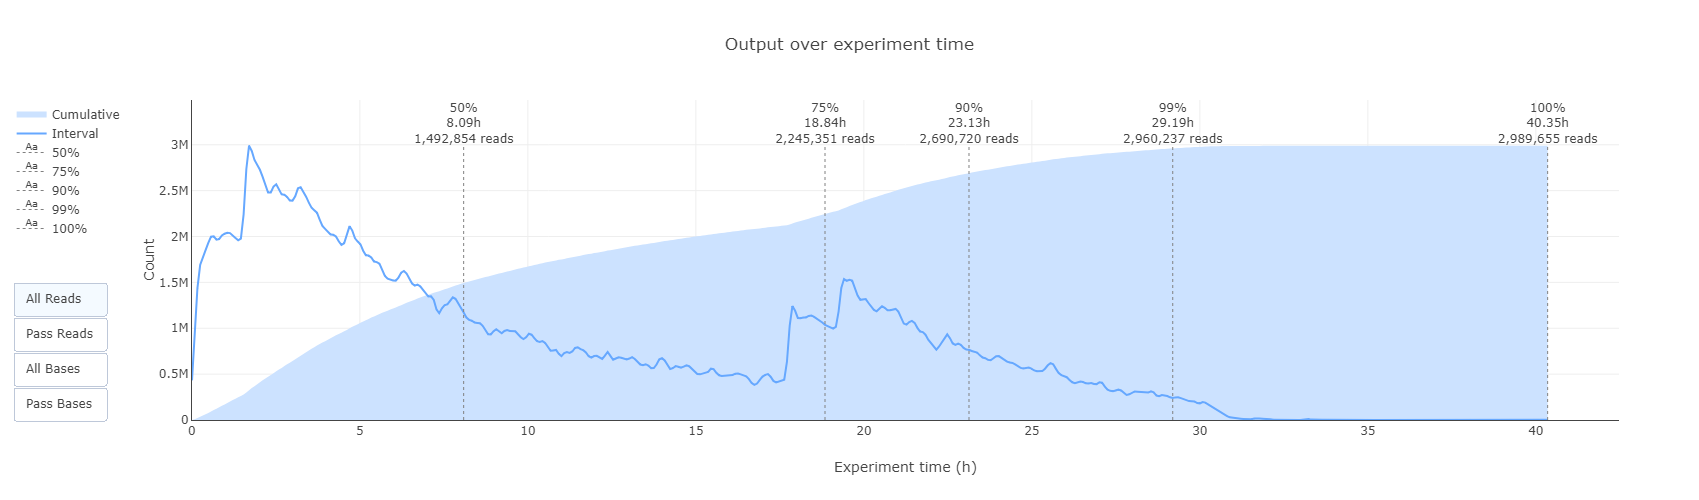

In [4]:

qtest = pycoQC("/mnt/smb/labfile/Backup/PromethION/basecalled/*Lump*/*/sequencing_summary/*.sequencing_summary.txt", verbose_level=0)

fig1 = qtest.summary()
iplot (fig1, show_link=False)

fig2 = qtest.reads_len_1D()
iplot (fig2, show_link=False)

fig3 = qtest.reads_qual_1D()
iplot(fig3, show_link=False)

fig4 = qtest.output_over_time()
iplot(fig4, show_link=False)

coverage for 600 Mb genome:  42.580336285


/local/genome/packages/anaconda3/latest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Quality distribution of Flowcells')

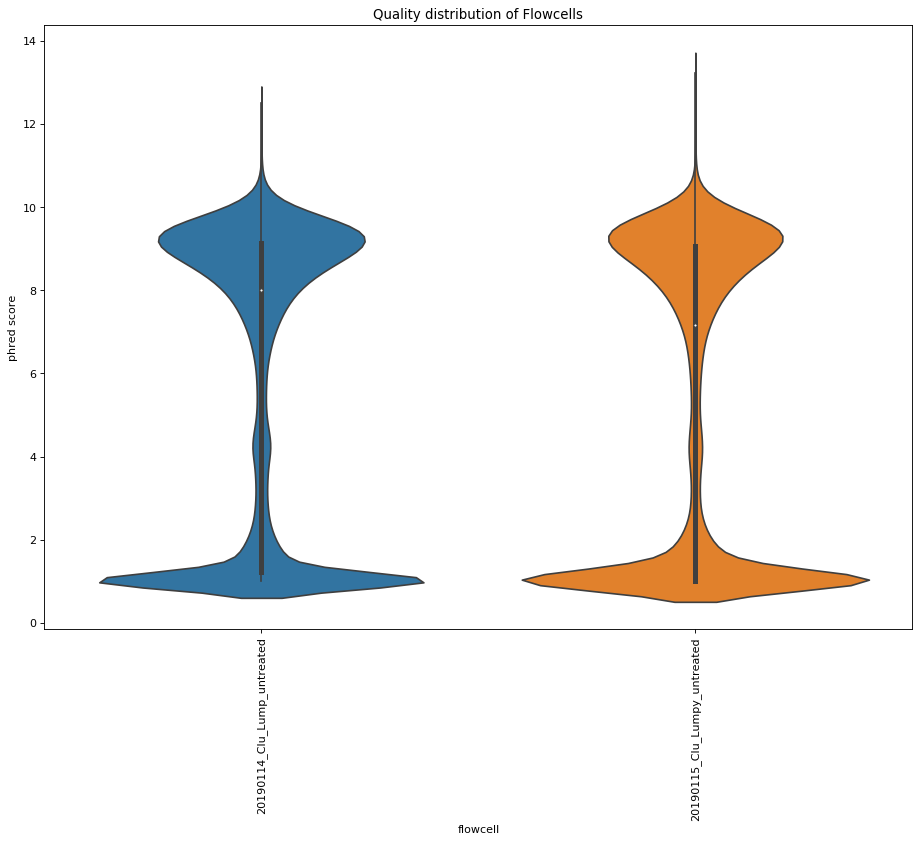

In [3]:
dfL = pd.read_csv("/net/cn-1/mnt/SCRATCH/michelmo/Projects/flowcells/Clu.flowcells.status.20190115.txt",  delimiter=" ", header=0)

print("coverage for 600 Mb genome: ", dfL["length"].sum() / 600000000)

plt.figure(figsize = (14,10), dpi = 80,facecolor='w', edgecolor='k' )
plt.tight_layout()
ax = sns.violinplot(x="flowcell", y="quality", data=dfL)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel='flowcell', ylabel='phred score')
ax.set_title('Quality distribution of Flowcells')

Text(0.5, 1.0, 'Quality distribution of Flowcells, only Q > 7')

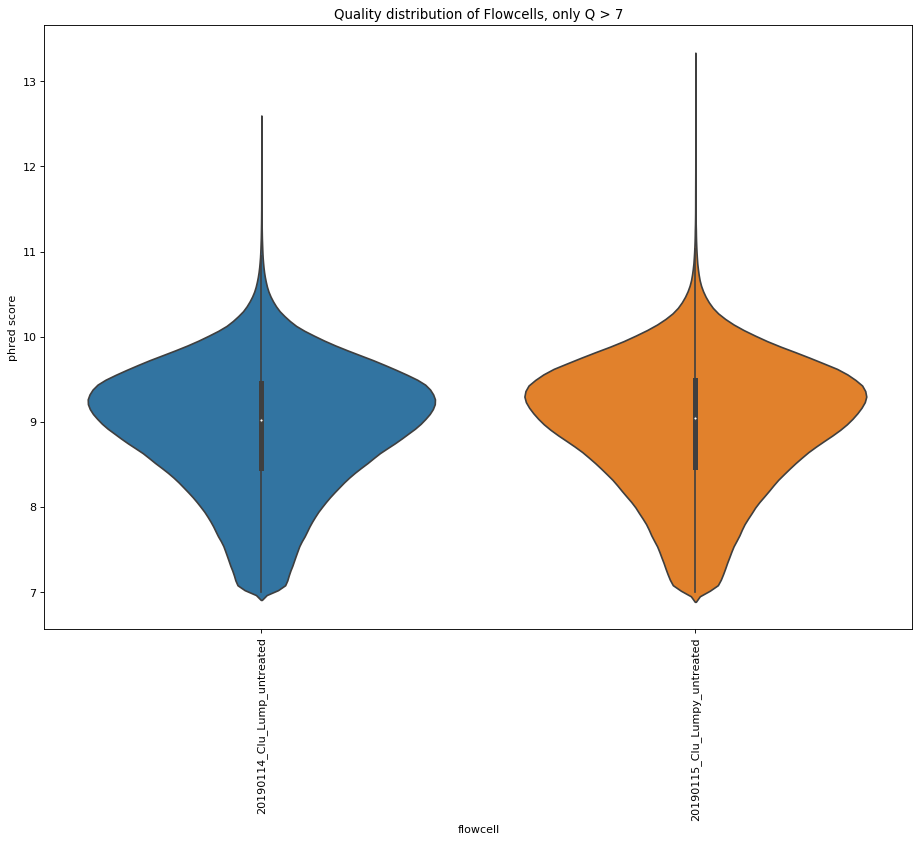

In [24]:
plt.figure(figsize = (14,10), dpi = 80,facecolor='w', edgecolor='k' )
plt.tight_layout()
ax = sns.violinplot(x="flowcell", y="quality", data=dfL.loc[dfL['quality'] > 7])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel='flowcell', ylabel='phred score')
ax.set_title('Quality distribution of Flowcells, only Q > 7')

# Raw read processing

## porechopped and fastp processed

### porechop command

`docker run -i --volume /data:/data hadrieng/porechop porechop --threads $CPUS -i $FASTQ -o $OUTPUT > ${OUTPUT}.txt`

### fastp command

`
zcat $(find /mnt/smb/labfile/Backup/PromethION/basecalled/*Lump* -name \*chopped.fastq.gz ) | $BINDIR/fastp -w 16 --stdin -z 4 -o ${OUTFILE} -V  --disable_trim_poly_g --disable_adapter_trimming -q 7 -l 4000 -f 50
`

#### output read files: 
`/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Clum.Leo.20190115.4kb.q7.50h.fastq.gz`
 



In [54]:
dfL = pd.read_csv("/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Clum.Leo.20190115.4kb.q7.50h.fastq.stats",  delimiter=" ", header=0)

dfL.head()
print("total yield: " + str(dfL["length"].sum()))
print("total reads: " + str(len(dfL.index)) )
print("mean read length: " + str(dfL["length"].sum()/ len(dfL.index)) + "\n")

print("coverage for 600 Mb genome: ", dfL["length"].sum() / 600000000)

total yield: 22243029604
total reads: 1067103
mean read length: 20844.313626707077

coverage for 600 Mb genome:  37.07171600666667


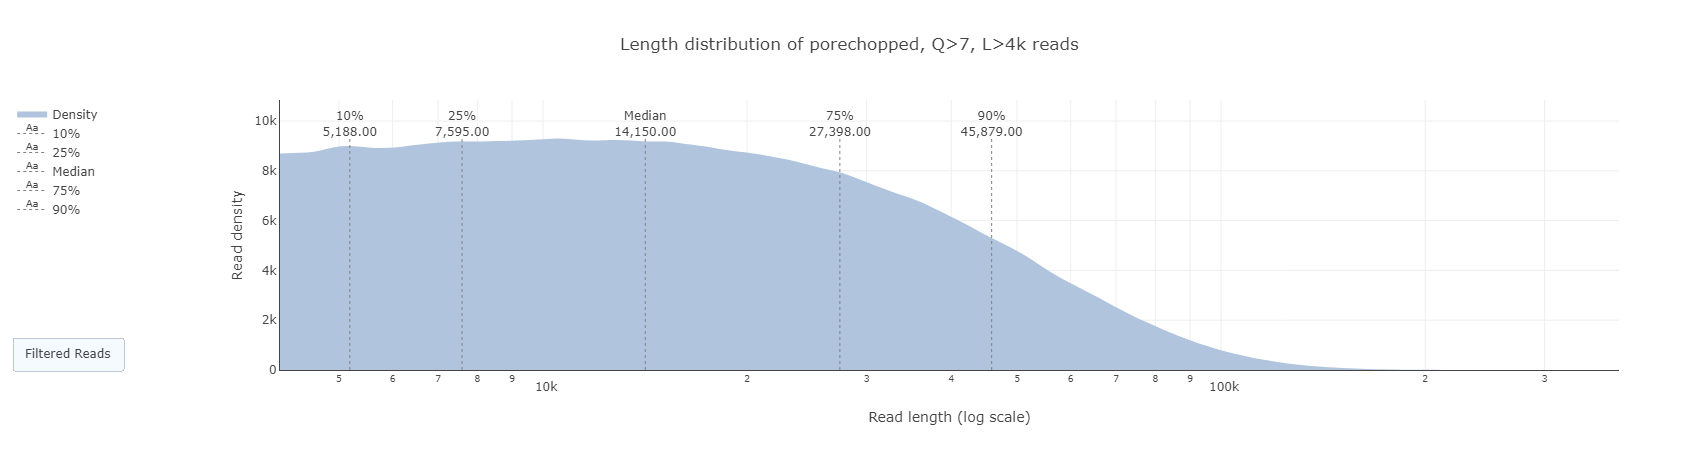

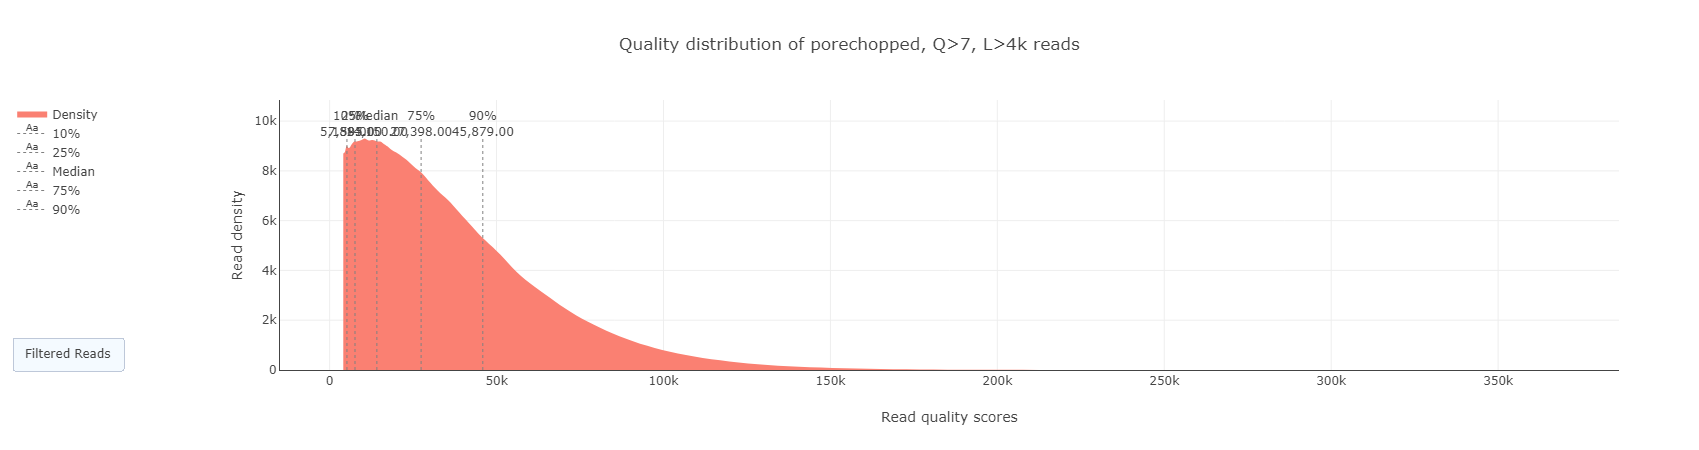

In [53]:
min_pass_qual = 7
df = dfL.rename(columns={'length': 'num_bases', 'quality' : 'mean_qscore'})

#display(df.head())
#display(df.shape)
#display(dfL.shape)

    
color="lightsteelblue"
width=None
height=500
nbins=200
smooth_sigma=2
sample=1000000
plot_title="Length distribution of porechopped, Q>7, L>4k reads"   
xscale = "log"
    
    
pass_df = df[df["mean_qscore"]>=min_pass_qual]
        
dd1, ld1 = reads_1D_data(df, field_name="num_bases", xscale="log", nbins=nbins, smooth_sigma=smooth_sigma, sample=sample)
dd2, ld2 = reads_1D_data (pass_df, field_name="num_bases", xscale="log", nbins=nbins, smooth_sigma=smooth_sigma, sample=sample)

line_style = {'color':'gray','width':1,'dash': 'dot'}
data = [
            go.Scatter (x=dd1["x"][0], y=dd1["y"][0], name=dd1["name"][0], fill='tozeroy', fillcolor=color, mode='none', showlegend=True),
            go.Scatter (x=dd1["x"][1], y=dd1["y"][1], name=dd1["name"][1], text=dd1["text"][1], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][2], y=dd1["y"][2], name=dd1["name"][2], text=dd1["text"][2], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][3], y=dd1["y"][3], name=dd1["name"][3], text=dd1["text"][3], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][4], y=dd1["y"][4], name=dd1["name"][4], text=dd1["text"][4], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][5], y=dd1["y"][5], name=dd1["name"][5], text=dd1["text"][5], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style)]

updatemenus = [
            dict (type="buttons", active=0, x=-0.2, y=0, xanchor='left', yanchor='bottom', buttons = [
                dict (label='Filtered Reads', method='update', args=[dd1, ld1])])]
                  
# tweak plot layout
layout = go.Layout (
            hovermode="closest",
            legend={"x":-0.2, "y":1,"xanchor":'left',"yanchor":'top'},
            updatemenus=updatemenus,
            width=width,
            height=height,
            title = plot_title,
            xaxis = {"title":"Read length (log scale)", "type":"log", "zeroline":False, "showline":True},
            yaxis = {"title":"Read density", "zeroline":False, "showline":True, "fixedrange":True, "range":ld1["yaxis.range"]})

figure = go.Figure (data=data, layout=layout)
iplot(figure)






#quality plot 

color="salmon"
width=None
height=500
nbins=200
smooth_sigma=2
sample=100000,
plot_title1="Quality distribution of porechopped, Q>7, L>4k reads"   

        # Plot initial data
line_style = {'color':'gray','width':1,'dash': 'dot'}
data1 = [
            go.Scatter (x=dd1["x"][0], y=dd1["y"][0], name=dd1["name"][0], fill='tozeroy', fillcolor=color, mode='none', showlegend=True),
            go.Scatter (x=dd1["x"][1], y=dd1["y"][1], name=dd1["name"][1], text=dd1["text"][1], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][2], y=dd1["y"][2], name=dd1["name"][2], text=dd1["text"][2], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][3], y=dd1["y"][3], name=dd1["name"][3], text=dd1["text"][3], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][4], y=dd1["y"][4], name=dd1["name"][4], text=dd1["text"][4], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style),
            go.Scatter (x=dd1["x"][5], y=dd1["y"][5], name=dd1["name"][5], text=dd1["text"][5], mode="lines+text", hoverinfo="skip", textposition='top center', line= line_style)]

        # Create update buttons
updatemenus1 = [
            dict (type="buttons", active=0, x=-0.2, y=0, xanchor='left', yanchor='bottom', buttons = [
                dict (label='Filtered Reads', method='update', args=[dd1, ld1])])]

        # tweak plot layout
layout1 = go.Layout (
            hovermode = "closest",
            legend = {"x":-0.2, "y":1,"xanchor":'left',"yanchor":'top'},
            updatemenus = updatemenus1,
            width = width,
            height = height,
            title = plot_title1,
            xaxis = {"title":"Read quality scores", "zeroline":False, "showline":True},
            yaxis = {"title":"Read density", "zeroline":False, "showline":True, "fixedrange":True, "range":ld1["yaxis.range"]})

figure1 = go.Figure (data=data1, layout=layout1)
iplot(figure1)








# <center>Genome assembly 
----
###  wtdbg2

`$APPDIR/wtdbg2 -t $CPUS -p 20 -AS 2 -s 0.05 -L 10000 -K 800 -g 0.7g -fo $PREFIX $OUTFILE`   
`zcat ${PREFIX}.ctg.lay.gz | $APPDIR/wtpoa-cns -t $CPUS -fo ${PREFIX}.ctg.lay.fa`

####  output assembly fasta: 

`/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Leo_the_Lumpfish.L10K.q7.h50.p20.ctg.lay.fa`

###  assembly stats: 

In [7]:
import pytablewriter

with open("/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/asm/Leo_the_Lumpfish.L10K.q7.h50.p20.ctg.lay.fa.stats") as LL1:
    for line in LL1:
        print(line)

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "example_table"
writer.header_list = ["int", "float", "str", "bool", "mix", "time"]
writer.value_matrix = [
    [0,   0.1,      "hoge", True,   0,      "2017-01-01 03:04:05+0900"],
    [2,   "-2.23",  "foo",  False,  None,   "2017-12-23 45:01:23+0900"],
    [3,   0,        "bar",  "true",  "inf", "2017-03-03 33:44:55+0900"],
    [-10, -9.9,     "",     "FALSE", "nan", "2017-01-01 00:00:00+0900"],
]

writer.write_table()

stats for Leo_the_Lumpfish.L10K.q7.h50.p20.ctg.lay.fa	sum = 552257341 n = 768, ave = 719085.08, largest = 19978013	N50 = 4993668, n = 30	N60 = 3856996, n = 43	N70 = 2972552, n = 59	N80 = 1719322, n = 84	N90 = 1112763, n = 123	N100 = 1873, n = 768	N_count = 0	Gaps = 0

# example_table
|int|float|str |bool |  mix   |          time          |
|--:|----:|----|-----|-------:|------------------------|
|  0| 0.10|hoge|True |       0|2017-01-01 03:04:05+0900|
|  2|-2.23|foo |False|        |2017-12-23 45:01:23+0900|
|  3| 0.00|bar |True |Infinity|2017-03-03 33:44:55+0900|
|-10|-9.90|    |False|     NaN|2017-01-01 00:00:00+0900|







```
sum = 552257341, n = 768   
ave = 719085.08    
largest = 19978013  
N50 = 4993668, n = 30   
N60 = 3856996, n = 43   
N70 = 2972552, n = 59   
N80 = 1719322, n = 84   
N90 = 1112763, n = 123   
N100 = 1873, n = 768   
```




## assembly polishing (evaluation with BUSCO)

### Racon

run racon
```md
#data
ASSEMBLY=/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Leo_the_Lumpfish.L10K.q7.h50.p20.ctg.lay.fa
FASTQ=/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Clum.Leo.20190115.4kb.q7.50h.fastq.gz
PAF=LL.1.p20.ONT20190115.paf

$MINIMAPDIR/minimap2 -x ava-ont -t ${CPUS} $ASSEMBLY $FASTQ > $PAF

$RACON/racon -u -t $CPUS $FASTQ $PAF $ASSEMBLY
```


run BUSCO
```
 python /mnt/users/michelmo/tools/busco/scripts/run_BUSCO.py -i $ASSEMBLY -o ${ASSEMBLY}_busco -l /net/fs-1/home01/michelmo/tools/busco/datasets/actinopterygii_odb9/ -m genome -c 16 -sp zebrafish
```


#### round 0 (no polishing)

`
BUSCO score:        C:22.4%[S:22.2%,D:0.2%],F:7.7%,M:69.9%,n:4584
`

#### round 1
`
BUSCO score:        C:56.4%[S:55.7%,D:0.7%],F:10.3%,M:33.3%,n:4584
`


#### round 2

`
BUSCO score:        C:57.1%[S:56.0%,D:1.1%],F:11.1%,M:31.8%,n:4584
`


### Medaka

run medaka
```
#data
DRAFT=/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Leo_the_Lumpfish.L10K.q7.h50.p20.ctg.lay.fa
BASECALLS=/net/cn-1/mnt/SCRATCH/michelmo/Projects/Lumpfish/data/Clum.Leo.20190115.4kb.q7.50h.fastq.gz

OUTDIR=medaka_consensus

medaka_consensus -i ${BASECALLS} -d ${DRAFT} -o ${OUTDIR} -t ${NPROC} -m r94
```





Medaka polishing on round 0 (raw output from wtdbg2-cns)

`
BUSCO score:        C:71.9%[S:70.5%,D:1.4%],F:9.6%,M:18.5%,n:4584
`

Medaka polishing on Racon round 2 LL1RR2

`
BUSCO score:   #TODO
`



